In [3]:
import os
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import math
import seaborn as sns
import scipy
from scipy import sparse
from scipy.stats import spearmanr, pearsonr
from scipy.spatial import distance_matrix
from scipy import stats
from scipy.stats import ranksums
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

from multiprocessing import Pool
from statsmodels.stats import multitest

In [8]:
'load deviation'
sc_deviation_df = pd.read_csv('/home/qukun/chenkx28/GBM/scATAC/data/deviation_chromVAR.csv', index_col = 0)
meta_df = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/ATAC_matrix/signac_result/gbm_atac_meta_data.csv',index_col=0)
sc_deviation_df = sc_deviation_df[meta_df.index]

'generate average'
deviation_average = pd.DataFrame(index=sc_deviation_df.index,columns=list(set(meta_df['predicted.id'])))
for cluster in deviation_average.columns:
    deviation_average[cluster] = sc_deviation_df[meta_df.loc[meta_df['predicted.id'] == cluster].index].mean(axis=1)

'merge proportion table'
slide_list = ['P77_A1','P77_B1','P130_C1','P130_D1','P131_A1','P131_B1','P136_C1','P136_D1','P137_A1','P137_B1','Visium_S1']

merge_proportion = pd.DataFrame()
for slide in slide_list:
    tmp = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/visium_matrix/spatial_ATAC/g05s_' + slide + '_cluster_cells.prob_assign_divSum.csv',index_col=0)
    tmp.index = [ item.split('-')[0] + '-' + slide for item in tmp.index]
    merge_proportion = pd.concat([merge_proportion,tmp])
    

In [11]:
'load spatial domain'
spatial_domain = pd.read_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/visium_matrix/spatial_domain_table_ER.csv',index_col=0)

'filter small cluster'
select_clusters = pd.DataFrame(meta_df.value_counts('predicted.id')).index[:-1].tolist()

'deviation matrix'
all_cluster_deviation = pd.DataFrame(columns=deviation_average.index,index=merge_proportion.index)
for spot in merge_proportion.index:
    all_cluster_deviation.loc[spot] = np.sum(deviation_average[select_clusters] * merge_proportion[select_clusters].loc[spot],axis=1)
    

In [ ]:
'Load P77-1 for demonstration'
cell_count = pd.read_csv('/home/qukun/ccp1997/GBM_10X/used_analysis/analysis_part3/visium/totle/P77_A1/P77_A1_spot_cell_counts.csv',index_col=0)

coordinates = pd.read_csv('/home/qukun/ccp1997/GBM_10X/used_analysis/analysis_part3/visium/totle/P77_A1/coordinates.csv',index_col=0)
coordinates = coordinates.loc[cell_count.index]

coordinates['row']  = [ max(coordinates['imagecol'])-(item - min(coordinates['imagecol'])) for item in coordinates['imagerow']]            
tem = pd.read_csv('/home/qukun/ccp1997/GBM_10X/used_analysis/analysis_part3/visium/totle/P77_A1/coordinates.csv',index_col=0)
tem = tem.loc[cell_count.index]
coordinates['row_position'] = tem['row']
coordinates.index = [ item.split('-')[0] + '-' + 'P77_A1' for item in coordinates.index]


In [19]:
'Filter out incorrectly predicted spots by tangram'

ER1_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == 'STME-1'].index, all_cluster_deviation.index )
ER1_spots_filter = merge_proportion.loc[ER1_spots].loc[np.sum(merge_proportion.loc[ER1_spots][['MES-like','TAM5','Monocytes']],axis=1) >= 0.2].index.tolist()

ER2_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == 'STME-2'].index, all_cluster_deviation.index )
ER2_spots_filter = merge_proportion.loc[ER2_spots].loc[np.sum(merge_proportion.loc[ER2_spots][['Endo','Pericyte']],axis=1) >= 0.2].index.tolist()

ER3_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == 'STME-3'].index, all_cluster_deviation.index )
ER3_spots_filter = merge_proportion.loc[ER3_spots].loc[np.sum(merge_proportion.loc[ER3_spots][['OPC-like','NPC-like']],axis=1) >= 0.2].index.tolist()

ER4_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == 'STME-4'].index, all_cluster_deviation.index )
ER4_spots_filter = merge_proportion.loc[ER4_spots].loc[np.sum(merge_proportion.loc[ER4_spots][['AC-like']],axis=1) >= 0.2].index.tolist()


In [21]:
[len(ER1_spots),len(ER2_spots),len(ER3_spots),len(ER4_spots)]

[6125, 2351, 4805, 13957]

In [22]:
all_cluster_deviation_filter = all_cluster_deviation.loc[ER1_spots_filter + ER2_spots_filter + ER3_spots_filter + ER4_spots_filter]

In [23]:
ER_average = pd.DataFrame( columns=['STME-1','STME-2','STME-3','STME-4'],index= all_cluster_deviation_filter.columns)
ER_average['STME-1'] = all_cluster_deviation_filter.loc[ER1_spots_filter].mean().tolist()
ER_average['STME-2'] = all_cluster_deviation_filter.loc[ER2_spots_filter].mean().tolist()
ER_average['STME-3'] = all_cluster_deviation_filter.loc[ER3_spots_filter].mean().tolist()
ER_average['STME-4'] = all_cluster_deviation_filter.loc[ER4_spots_filter].mean().tolist()

In [24]:
maxium_list = []
for motif in ER_average.index:
    maxium_list.append( ER_average.columns[ER_average.loc[motif] == np.max(ER_average.loc[motif])][0] )
ER_average['max_er'] = maxium_list

In [ ]:
'ER-1 results'

In [31]:
def motif_diff(motif):
    ER = 'STME-1'
    select_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == ER].index, all_cluster_deviation_filter.index )
    others_spots = np.setdiff1d(all_cluster_deviation_filter.index,select_spots)
    in_cluster = np.mean(all_cluster_deviation_filter.loc[select_spots][motif])
    out_cluster = np.mean(all_cluster_deviation_filter.loc[others_spots][motif])
    delta = in_cluster - out_cluster
    p_values = ranksums( all_cluster_deviation_filter.loc[select_spots][motif] , all_cluster_deviation_filter.loc[others_spots][motif] )[1]
    result = [in_cluster,out_cluster,delta,p_values]
    return result

pool = Pool(80)
k = pool.map(motif_diff, all_cluster_deviation_filter.columns.tolist() )
pool.close()
pool.join()

ER1_motif_table = pd.DataFrame(k,index=all_cluster_deviation_filter.columns,columns=['in_cluster','out_cluster','delta','p_values'])
rejected, p_val_corrected = multitest.fdrcorrection(ER1_motif_table['p_values'], 
                                                        alpha=0.05, 
                                                        method='indep', 
                                                        is_sorted=False)
ER1_motif_table['FDR'] = p_val_corrected
minimum_value = ER1_motif_table.loc[ER1_motif_table['FDR'] != 0].sort_values('FDR')['FDR'][0]
ER1_motif_table['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER1_motif_table['FDR']]

ER1_motif_select =  ER1_motif_table.loc[np.intersect1d(ER1_motif_table.loc[ER1_motif_table['delta'] >= 0.1].index, ER_average.loc[ER_average['max_er'] == 'STME-1'].index)]

ER1_motif_final = ER1_motif_select.loc[((ER1_motif_select['in_cluster'] >= -0.5) & (ER1_motif_select['delta'] >= 0.1)) & (ER1_motif_select['logFDR'] >= 2)].sort_values('delta',ascending=False)          

ranking = ER1_motif_final.loc[ER1_motif_final['logFDR'] == np.max(ER1_motif_final['logFDR'])].sort_values('delta',ascending=False).index.tolist() +\
ER1_motif_final.loc[ER1_motif_final['logFDR'] != np.max(ER1_motif_final['logFDR'])].sort_values('logFDR',ascending=False).index.tolist()
ER1_motif_final = ER1_motif_final.loc[ranking]

ER1_motif_final.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/ATAC_matrix/ER1_diff_TF.csv')

In [ ]:
'showcase'

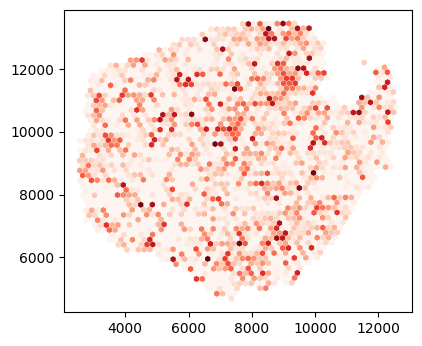

In [14]:
gene = 'HIF1A-MA1106.1'
ratio = ( np.max(coordinates['row']) - np.min(coordinates['row']) ) / ( np.max(coordinates['imagecol']) - np.min(coordinates['imagecol']) )
plt.figure(figsize=(4.5,4.5*ratio))
plt.scatter(x=coordinates['imagecol'],y=coordinates['row'],s=20,marker='h',c= all_cluster_deviation.loc[coordinates.index][gene] ,cmap ='Reds',alpha=1, linewidths=0.01,edgecolors='grey',vmin=0,vmax=0.6,rasterized=True)                 
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_4/motif_figure/P77_A1_HIF1A-MA1106.1.pdf',dpi=500)


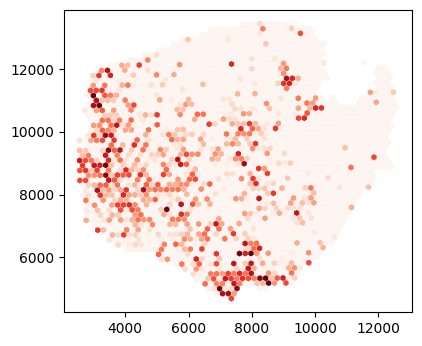

In [13]:
gene = 'ATF4-MA0833.1'
ratio = ( np.max(coordinates['row']) - np.min(coordinates['row']) ) / ( np.max(coordinates['imagecol']) - np.min(coordinates['imagecol']) )
plt.figure(figsize=(4.5,4.5*ratio))
plt.scatter(x=coordinates['imagecol'],y=coordinates['row'],s=20,marker='h',c= all_cluster_deviation.loc[coordinates.index][gene] ,cmap ='Reds',alpha=1, linewidths=0.01,edgecolors='grey',vmin=0,vmax=2.5,rasterized=True)                 
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_4/motif_figure/P77_A1_ATF4-MA0833.1.pdf',dpi=500)


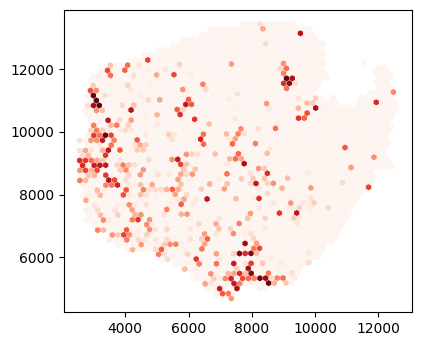

In [462]:
gene = 'CEBPD-MA0836.1'
ratio = ( np.max(coordinates['row']) - np.min(coordinates['row']) ) / ( np.max(coordinates['imagecol']) - np.min(coordinates['imagecol']) )
plt.figure(figsize=(4.5,4.5*ratio))
plt.scatter(x=coordinates['imagecol'],y=coordinates['row'],s=20,marker='h',c= all_cluster_deviation.loc[coordinates.index][gene] ,cmap ='Reds',alpha=1, linewidths=0.01,edgecolors='grey',vmin=0,vmax=3.5,rasterized=True)                 
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_4/motif_figure/P77_A1_CEBPD-MA0836.1.pdf',dpi=500)


In [ ]:
'ER-2 results'

In [42]:
def motif_diff(motif):
    ER = 'STME-2'
    select_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == ER].index, all_cluster_deviation_filter.index )
    others_spots = np.setdiff1d(all_cluster_deviation_filter.index,select_spots)
    in_cluster = np.mean(all_cluster_deviation_filter.loc[select_spots][motif])
    out_cluster = np.mean(all_cluster_deviation_filter.loc[others_spots][motif])
    delta = in_cluster - out_cluster
    p_values = ranksums( all_cluster_deviation_filter.loc[select_spots][motif] , all_cluster_deviation_filter.loc[others_spots][motif] )[1]
    result = [in_cluster,out_cluster,delta,p_values]
    return result

pool = Pool(80)
k = pool.map(motif_diff, all_cluster_deviation_filter.columns.tolist() )
pool.close()
pool.join()

ER2_motif_table = pd.DataFrame(k,index=all_cluster_deviation_filter.columns,columns=['in_cluster','out_cluster','delta','p_values'])
rejected, p_val_corrected = multitest.fdrcorrection(ER2_motif_table['p_values'], 
                                                        alpha=0.05, 
                                                        method='indep', 
                                                        is_sorted=False)
ER2_motif_table['FDR'] = p_val_corrected
minimum_value = ER2_motif_table.loc[ER2_motif_table['FDR'] != 0].sort_values('FDR')['FDR'][0]
ER2_motif_table['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER2_motif_table['FDR']]

ER2_motif_select =  ER2_motif_table.loc[np.intersect1d(ER2_motif_table.loc[ER2_motif_table['delta'] >= 0.10].index, ER_average.loc[ER_average['max_er'] == 'STME-2'].index)]

ER2_motif_final = ER2_motif_select.loc[((ER2_motif_select['in_cluster'] >= -0.5) & (ER2_motif_select['delta'] >= 0.10)) & (ER2_motif_select['logFDR'] >= 2)].sort_values('delta',ascending=False)          

ranking = ER2_motif_final.loc[ER2_motif_final['logFDR'] == np.max(ER2_motif_final['logFDR'])].sort_values('delta',ascending=False).index.tolist() +\
ER2_motif_final.loc[ER2_motif_final['logFDR'] != np.max(ER2_motif_final['logFDR'])].sort_values('logFDR',ascending=False).index.tolist()
ER2_motif_final = ER2_motif_final.loc[ranking]

ER2_motif_final.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/ATAC_matrix/ER2_diff_TF.csv')

In [ ]:
'ER-3 results'

In [51]:
def motif_diff(motif):
    ER = 'STME-3'
    select_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == ER].index, all_cluster_deviation_filter.index )
    others_spots = np.setdiff1d(all_cluster_deviation_filter.index,select_spots)
    in_cluster = np.mean(all_cluster_deviation_filter.loc[select_spots][motif])
    out_cluster = np.mean(all_cluster_deviation_filter.loc[others_spots][motif])
    delta = in_cluster - out_cluster
    p_values = ranksums( all_cluster_deviation_filter.loc[select_spots][motif] , all_cluster_deviation_filter.loc[others_spots][motif] )[1]
    result = [in_cluster,out_cluster,delta,p_values]
    return result

pool = Pool(80)
k = pool.map(motif_diff, all_cluster_deviation_filter.columns.tolist() )
pool.close()
pool.join()

ER3_motif_table = pd.DataFrame(k,index=all_cluster_deviation_filter.columns,columns=['in_cluster','out_cluster','delta','p_values'])
rejected, p_val_corrected = multitest.fdrcorrection(ER3_motif_table['p_values'], 
                                                        alpha=0.05, 
                                                        method='indep', 
                                                        is_sorted=False)
ER3_motif_table['FDR'] = p_val_corrected
minimum_value = ER3_motif_table.loc[ER3_motif_table['FDR'] != 0].sort_values('FDR')['FDR'][0]
ER3_motif_table['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER3_motif_table['FDR']]

ER3_motif_select =  ER3_motif_table.loc[np.intersect1d(ER3_motif_table.loc[ER3_motif_table['delta'] >= 0.1].index, ER_average.loc[ER_average['max_er'] == 'STME-3'].index)]

ER3_motif_final = ER3_motif_select.loc[((ER3_motif_select['in_cluster'] >= -0.5) & (ER3_motif_select['delta'] >= 0.1)) & (ER3_motif_select['logFDR'] >= 2)].sort_values('delta',ascending=False)          

ranking = ER3_motif_final.loc[ER3_motif_final['logFDR'] == np.max(ER3_motif_final['logFDR'])].sort_values('delta',ascending=False).index.tolist() +\
ER3_motif_final.loc[ER3_motif_final['logFDR'] != np.max(ER3_motif_final['logFDR'])].sort_values('logFDR',ascending=False).index.tolist()
ER3_motif_final = ER3_motif_final.loc[ranking]

ER3_motif_final.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/ATAC_matrix/ER3_diff_TF.csv')

In [ ]:
'ER-4 results'

In [59]:
def motif_diff(motif):
    ER = 'STME-4'
    select_spots = np.intersect1d( spatial_domain.loc[spatial_domain['STME'] == ER].index, all_cluster_deviation_filter.index )
    others_spots = np.setdiff1d(all_cluster_deviation_filter.index,select_spots)
    in_cluster = np.mean(all_cluster_deviation_filter.loc[select_spots][motif])
    out_cluster = np.mean(all_cluster_deviation_filter.loc[others_spots][motif])
    delta = in_cluster - out_cluster
    p_values = ranksums( all_cluster_deviation_filter.loc[select_spots][motif] , all_cluster_deviation_filter.loc[others_spots][motif] )[1]
    result = [in_cluster,out_cluster,delta,p_values]
    return result

pool = Pool(80)
k = pool.map(motif_diff, all_cluster_deviation_filter.columns.tolist() )
pool.close()
pool.join()

ER4_motif_table = pd.DataFrame(k,index=all_cluster_deviation_filter.columns,columns=['in_cluster','out_cluster','delta','p_values'])
rejected, p_val_corrected = multitest.fdrcorrection(ER4_motif_table['p_values'], 
                                                        alpha=0.05, 
                                                        method='indep', 
                                                        is_sorted=False)
ER4_motif_table['FDR'] = p_val_corrected
minimum_value = ER4_motif_table.loc[ER4_motif_table['FDR'] != 0].sort_values('FDR')['FDR'][0]
ER4_motif_table['logFDR'] = [ -1 * math.log10(item+minimum_value) for item in ER4_motif_table['FDR']]

ER4_motif_select =  ER4_motif_table.loc[np.intersect1d(ER4_motif_table.loc[ER4_motif_table['delta'] >= 0.1].index, ER_average.loc[ER_average['max_er'] == 'STME-4'].index)]
ER4_motif_final = ER4_motif_select.loc[((ER4_motif_select['in_cluster'] >= -0.5) & (ER4_motif_select['delta'] >= 0.1)) & (ER4_motif_select['logFDR'] >= 2)].sort_values('delta',ascending=False)          

ranking = ER4_motif_final.loc[ER4_motif_final['logFDR'] == np.max(ER4_motif_final['logFDR'])].sort_values('delta',ascending=False).index.tolist() +\
ER4_motif_final.loc[ER4_motif_final['logFDR'] != np.max(ER4_motif_final['logFDR'])].sort_values('logFDR',ascending=False).index.tolist()
ER4_motif_final = ER4_motif_final.loc[ranking]

ER4_motif_final.to_csv('/home/qukun/ccp1997/GBM_10X/ng_revised/ATAC_matrix/ER4_diff_TF.csv')

In [240]:
'heatmap'

'heatmap'

In [241]:
from random import sample
import random

In [242]:
ratio_1_2 = len(ER1_spots)/len(ER2_spots)
ratio_3_2 = len(ER3_spots)/len(ER2_spots)
ER1_for_plot = int(len(ER2_spots_filter) * ratio_1_2)
ER3_for_plot = int(len(ER2_spots_filter) * ratio_3_2)

In [243]:
ER1_for_plot_sample = sample(ER1_spots_filter,ER1_for_plot)
ER2_for_plot_sample = ER2_spots_filter
ER3_for_plot_sample = sample(ER3_spots_filter,ER3_for_plot)
ER4_for_plot_sample = sample(ER4_spots_filter,ER1_for_plot)

In [252]:
'smooth 10'

'smooth 10'

In [245]:
random.shuffle(ER1_for_plot_sample)
random.shuffle(ER2_for_plot_sample)
random.shuffle(ER3_for_plot_sample)
random.shuffle(ER4_for_plot_sample)

In [246]:
# split a list to N chunks
def chunks(arr, m):
    n = int(math.ceil(len(arr) / float(m)))
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [247]:
smooth_ratio = 10
ER1_chunked = chunks(ER1_for_plot_sample,math.ceil(len(ER1_for_plot_sample)/smooth_ratio))
ER2_chunked = chunks(ER2_for_plot_sample,math.ceil(len(ER2_for_plot_sample)/smooth_ratio))
ER3_chunked = chunks(ER3_for_plot_sample,math.ceil(len(ER3_for_plot_sample)/smooth_ratio))
ER4_chunked = chunks(ER4_for_plot_sample,math.ceil(len(ER4_for_plot_sample)/smooth_ratio))

In [248]:
smooth_exp_matrix = pd.DataFrame(index= all_cluster_deviation_filter.columns)
for item in range(len(ER1_chunked)):
    smooth_exp_matrix['ER1'+'-'+str(item)] = np.mean(all_cluster_deviation_filter.loc[ER1_chunked[item]])
    
for item in range(len(ER2_chunked)):
    smooth_exp_matrix['ER2'+'-'+str(item)] = np.mean(all_cluster_deviation_filter.loc[ER2_chunked[item]])
    
for item in range(len(ER3_chunked)):
    smooth_exp_matrix['ER3'+'-'+str(item)] = np.mean(all_cluster_deviation_filter.loc[ER3_chunked[item]])
    
for item in range(len(ER4_chunked)):
    smooth_exp_matrix['ER4'+'-'+str(item)] = np.mean(all_cluster_deviation_filter.loc[ER4_chunked[item]])

/home/qukun/ccp1997/miniconda3/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/home/qukun/ccp1997/miniconda3/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == "__main__":
/home/qukun/ccp1997/miniconda3/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

In [274]:
merge_motif_list = ER1_motif_final.index.tolist() + ER2_motif_final.index.tolist() + ER3_motif_final.index.tolist() + ER4_motif_final.index.tolist()
row_matrix = smooth_exp_matrix.loc[merge_motif_list]
row_matrix = row_matrix.astype(np.float64)

z_score_matrix = pd.DataFrame(index=row_matrix.index,columns=row_matrix.columns)
for motif in row_matrix.index:
    z_score_matrix.loc[motif] = scipy.stats.zscore(row_matrix.loc[motif])
z_score_matrix = z_score_matrix.astype(np.float64)

col_dataframe = pd.DataFrame(index=z_score_matrix.columns)
col_dataframe['ER'] = len(ER1_chunked) * ['#DC2373'] + len(ER2_chunked) * ['#A03826'] + len(ER3_chunked) * ['#5FBE9B'] + len(ER4_chunked) * ['#F4A947']

row_dataframe = pd.DataFrame(index=z_score_matrix.index)
row_dataframe['ER'] = len(ER1_motif_final.index) * ['#DC2373'] + len(ER2_motif_final.index) * ['#A03826'] + len(ER3_motif_final.index) * ['#5FBE9B'] + len(ER4_motif_final.index) * ['#F4A947']


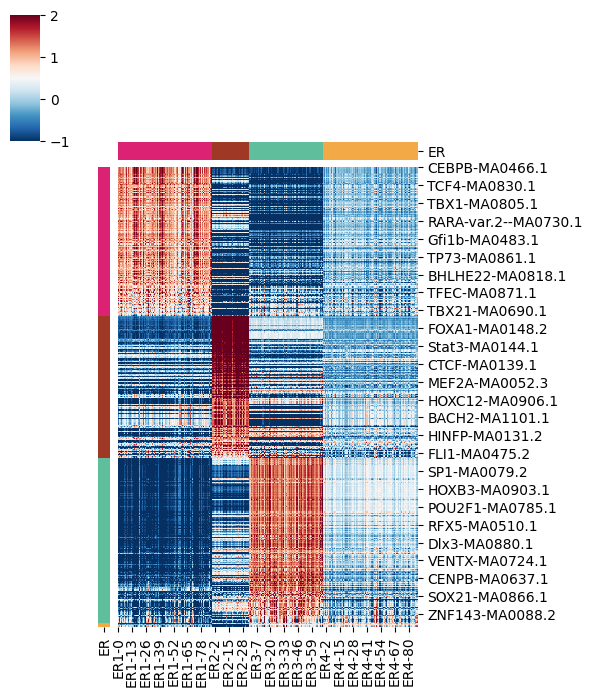

In [284]:
sns.clustermap(z_score_matrix,cmap='RdBu_r',vmin=-1,vmax=2,row_cluster=False,col_cluster=False,figsize=(6,7),col_colors=col_dataframe,row_colors=row_dataframe,rasterized=True)
plt.savefig('/home/qukun/ccp1997/GBM_10X/ng_revised/figure/result_4/spatial_ATAC_heatmap.pdf',dpi=500)
